In [2]:
!pip install wget
!pip install nptdms

In [1]:
%load_ext autoreload
%autoreload 2

import das_package as dp
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import scipy.signal as sp

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Downloading Raw Files (Download_data.ipynb)

### Task: Download the raw geoscientific dataset relevant to your project and discuss the basic modalities.

In [5]:
interrogator = "Silixa"     #Optasense or Silixa
ship_number = 1
folder = f"Data/Raw/Ship{ship_number}"
results_folder = f"{folder}/results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
url = "http://piweb.ooirsn.uw.edu/das/data/Silixa/DAS/South90km/2021-11-05/OOIPacCity_UTC_20211105_163824.042.tdms"
first_file_time = dp.find_time_url(url, interrogator)
file_timing_length = 15
minutes = 5
n = int(minutes*60/file_timing_length)
all_filenames = dp.dl_das_files(folder, url, first_file_time, file_timing_length, n)
filenames = sorted([file for file in all_filenames if file != f"{folder}\\results"])
print(filenames)

OOIPacCity_UTC_20211105_163824.042.tdms already stored locally
OOIPacCity_UTC_20211105_163839.042.tdms already stored locally
OOIPacCity_UTC_20211105_163854.042.tdms already stored locally
OOIPacCity_UTC_20211105_163909.042.tdms already stored locally
OOIPacCity_UTC_20211105_163924.042.tdms already stored locally
OOIPacCity_UTC_20211105_163939.042.tdms already stored locally
OOIPacCity_UTC_20211105_163954.042.tdms already stored locally
OOIPacCity_UTC_20211105_164009.042.tdms already stored locally
OOIPacCity_UTC_20211105_164024.042.tdms already stored locally
OOIPacCity_UTC_20211105_164039.042.tdms already stored locally
OOIPacCity_UTC_20211105_164054.042.tdms already stored locally
OOIPacCity_UTC_20211105_164109.042.tdms already stored locally
OOIPacCity_UTC_20211105_164124.042.tdms already stored locally
OOIPacCity_UTC_20211105_164139.042.tdms already stored locally
OOIPacCity_UTC_20211105_164154.042.tdms already stored locally
OOIPacCity_UTC_20211105_164209.042.tdms already stored 

# Loading Raw Data (Data_Cleaning.ipynb)

### Task: Clean the raw data to handle missing values, outliers, or inconsistencies.

In [6]:
if interrogator == 'Optasense':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.optasense(filenames)

elif interrogator == 'Silixa':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.silixa(filenames)


# Downsample factors and channel chunking size
if fs == 1000:
    factor_channels = 2
    factor_time = 5
    ch_chunk_size = 500
elif fs == 500:
    factor_channels = 2
    factor_time = 2
    ch_chunk_size = 700
elif fs == 200:
    factor_channels = 2
    factor_time = 1
    ch_chunk_size = 1000

[nptdms.tdms_segment WARNING] Data size 241536000 is not a multiple of the chunk size 1046656. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 241536000 is not a multiple of the chunk size 1046656. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 241536000 is not a multiple of the chunk size 1046656. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 241536000 is not a multiple of the chunk size 1046656. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 241536000 is not a multiple of the chunk size 1046656. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 241536000 is not a multiple of the chunk size 1046656. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 241536000 is not a multiple of the chunk size 1046656. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 241536000 is not a multiple of the chunk size 1046656. Will attempt to 

The concatenated data shape: (40256, 60000)


[nptdms.tdms_segment WARNING] Data size 241536000 is not a multiple of the chunk size 1046656. Will attempt to read last chunk


OrderedDict([('name', 'OOIPacCity_UTC_20211105_163824.042'), ('SamplingFrequency[Hz]', 200.0), ('SpatialResolution[m]', 2.0), ('Fibre Type', 'Standard'), ('Zone Type', 'Single-Zone'), ('Start Distance (m)', -297.862858), ('Stop Distance (m)', 81899.013567487), ('StreamTime[s]', inf), ('Continuous Mode', True), ('StartPosition[m]', 1.0), ('MeasureLength[m]', 80512), ('Zone Setup', False), ('Precise Sampling Frequency (Hz)', 1000.0), ('Zones', ''), ('Power Decrement', 0.0), ('Source Mode', 'Normal'), ('Time Decimation', 5), ('OutputDecimation[bool]', 1), ('P', 7), ('P Coefficients', '1.000000;1.000000;1.000000;1.000000;1.000000;1.000000;1.000000\r\n'), ('Integration Cut Off (Hz)', 3.14), ('Normalization', True), ('Decimation Filter', True), ('Acoustic Output', 'Differential'), ('Diagnostic Output', 'R, S, As & dP'), ('Window', 0), ('PeakVoltage[V]', 3.5), ('Pulse 2 Delay (ns)', 40.0), ('PulseWidth[ns]', 250.0), ('OffsetLength', 64.0), ('PreTrigSamples', 64), ('Reference length', 0), ('Sa

# Converting Raw Data to AI-Ready Data (Prepare_AI_Ready_Data.ipynb)

### Task: Prepare the cleaned data for machine learning, ensuring it is properly annotated and structured.

In [7]:
distance = [1000, 80000]
if dx<2:
    chint = 1
elif dx>=2:
    chint = 1
duration = [0, int(ns/fs)]            #in second1
tint = 1                         #time interval (sample)


#Converting selected distance from meter to channels
channels = [int(distance[0]/dx), int(distance[1]/dx), chint]

#Finding number of itterations
itteration = (((channels[1] - channels[0]) / chint)//ch_chunk_size)
print('Number of itterations: ', itteration)


### Raw to strain rate ###
#Determine the first chunck of data
channels_chunk = [int(distance[0]/dx), min(int(distance[0]/dx) + ch_chunk_size*chint , int(distance[1]/dx)), chint]
time_chunk = [int(duration[0]*fs), int(duration[1]*fs), tint]

#Doing analysis for first chunk of data
trace, dist, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
if interrogator == 'Optasense':
    str_rate = dp.strain2strainrate(trace, dt, tint)
elif interrogator == 'Silixa':
    str_rate = trace

#Doing analysis for remained chunks of data
for i in tqdm(range(int(itteration))):

    if (channels_chunk[1] + ch_chunk_size*chint)*dx >= distance[1]:
        channels_chunk = [channels_chunk[1], int(distance[1]/dx), chint]
    else:
        channels_chunk = [channels_chunk[1], channels_chunk[1] + ch_chunk_size*chint, chint]

    if channels_chunk[1] - channels_chunk[0] < 0.1*ch_chunk_size :
        break

    trace, dist_chunk, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
    dist = np.concatenate([dist, dist_chunk])
    if interrogator == 'Optasense':
        str_rate_chunk = dp.strain2strainrate(trace, dt, tint)
    elif interrogator == 'Silixa':
        str_rate_chunk = trace
    str_rate = np.concatenate([str_rate, str_rate_chunk], axis=0)
    del str_rate_chunk, dist_chunk

np.save(f'{folder}/results/str_rate{ship_number}', str_rate)
np.save(f'{folder}/results/time{ship_number}', time)
np.save(f'{folder}/results/dist{ship_number}', dist)

del trace, rawData

if interrogator == 'Optasense':
    files = glob.glob(os.path.join(folder, '*.h5'))
    print(files)
    for file in files:
        os.remove(file)

elif interrogator == 'Silixa':
    files = glob.glob(os.path.join(folder, '*.tdms'))
    print(files)
    for file in files:
        os.remove(file)


Number of itterations:  39.0


100%|██████████| 39/39 [02:03<00:00,  3.17s/it]


['Data/Raw/Ship1\\OOIPacCity_UTC_20211105_163824.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_163839.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_163854.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_163909.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_163924.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_163939.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_163954.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_164009.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_164024.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_164039.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_164054.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_164109.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_164124.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_164139.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_164154.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_164209.042.tdms', 'Data/Raw/Ship1\\OOIPacCity_UTC_20211105_164224.042.tdm

# Downsampling the Data (Dimensionality_Reduction.ipynb)

### Task: Analyze the dimensionality of your dataset and propose methods to reduce it.



In [8]:
# Downsample the raw data
factor_channels = 1
factor_time = 1
str_rate_downsampled = block_reduce(str_rate, block_size=(factor_channels, factor_time), func=np.mean)
# Downsample the distance and time domain data
dist_downsampled = block_reduce(dist, block_size=factor_channels, func=np.mean)
time_downsampled = block_reduce(time, block_size=factor_time, func=np.mean)

# Exploratory Data Analysis

### Task: Perform a basic exploration of the cleaned data to understand its structure and key characteristics.

## Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

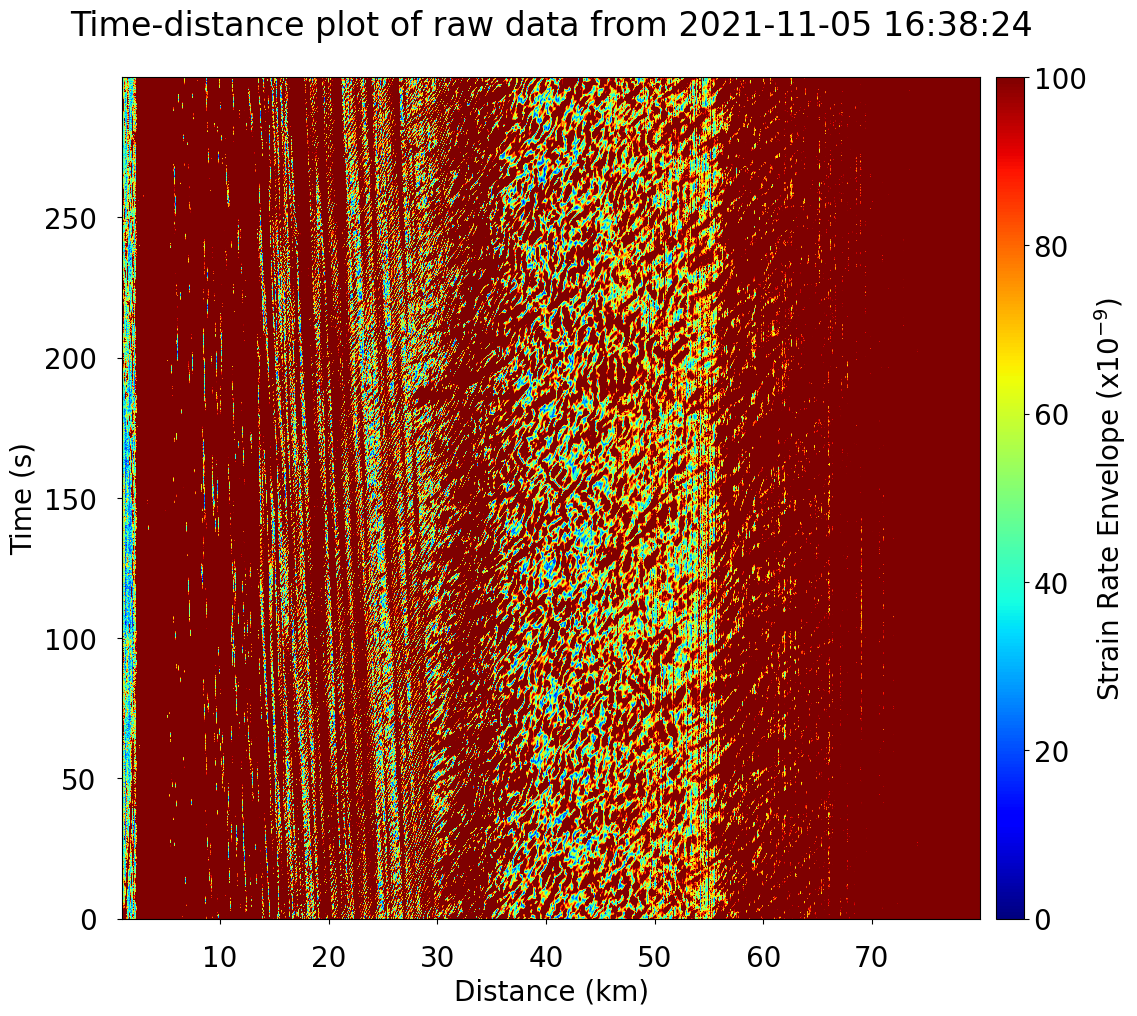

In [9]:
vmax = 100
dp.plot_tx(sp.hilbert(str_rate_downsampled[0:-2,:], axis=1), time_downsampled, dist_downsampled[0:-2], file_begin_time_utc=starting_time_utc, fig_size=(12, 10), v_min=0, v_max=vmax)
plt.title(f'Time-distance plot of raw data from {starting_time_utc.strftime("%Y-%m-%d %H:%M:%S")}', pad=30)
plt.show

## Downsampling the Data (PCA)

In [8]:
print(f"size of strain-rate data: {str_rate.shape}")

size of strain-rate data: (39500, 60000)


In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(str_rate)

# Step 1: Temporal PCA
pca = PCA(n_components=int(str_rate.shape[1]/1000))
str_rate_reduced = pca.fit_transform(scaled_data)  # Reduce time

In [10]:
print(f"size of reduced strain-rate data: {str_rate_reduced.shape}")

size of reduced strain-rate data: (39500, 60)


In [12]:
original_data = str_rate_reduced.copy()

## Creating metadata and classes

In [14]:
#make strain rate a pandas dataframe
import pandas as pd

#turn it into a 3d dataframe with time and distance
df = pd.DataFrame(str_rate_reduced)

#add label to the distance and time
df.index.name = 'Distance'
df.columns.name = 'Time'

#find number of columns
num_columns = len(df.columns)
print(num_columns)

c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


60


/tmp/ipykernel_14591/4282992658.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata = metadata.fillna(0)


start channel: 22500
end channel: 23500


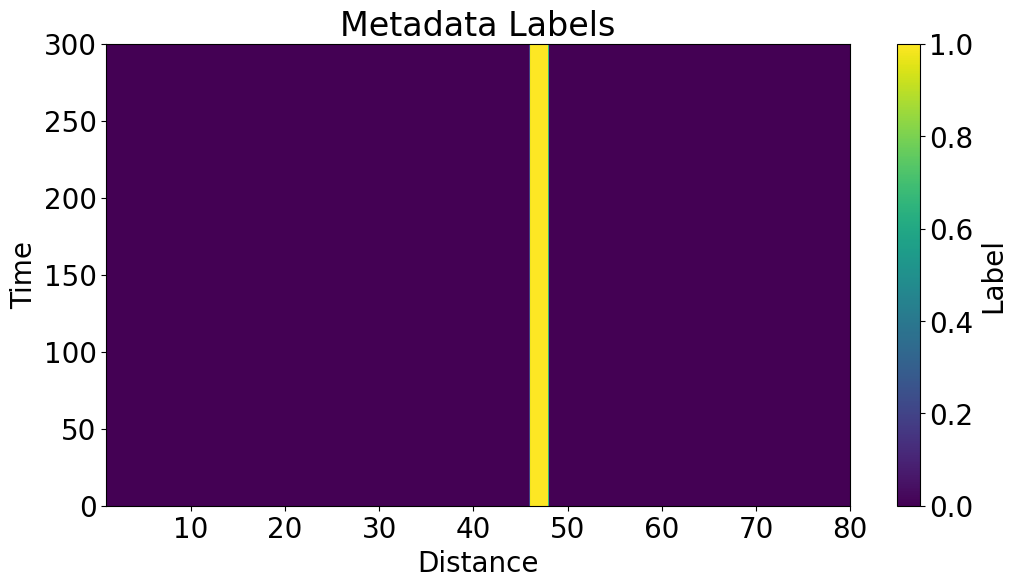

In [71]:
metadata = pd.DataFrame(index = df.index, columns = df.columns)
metadata = metadata.fillna(0)

# Defining distances where ship was present in our data
start_distance = 46000
end_distance = 48000

# add ship label to the metadata for points in the specified distance and time range from above
print(f"start channel: {int((start_distance-distance[0])/(dx*chint))}\nend channel: {int((end_distance-distance[0])/(dx*chint))}")
metadata.iloc[int((start_distance-distance[0])/(dx*chint)):int((end_distance-distance[0])/(dx*chint))] = 1

#plot the metadata to double check that the labels are correct and give values of 1 and 2 different colors
plt.figure(figsize=(12, 6))
plt.imshow(metadata.T, extent=[distance[0] * 1e-3, distance[-1] * 1e-3, duration[0], duration[-1]], aspect='auto', cmap='viridis')
plt.colorbar(label='Label')
plt.title('Metadata Labels')
plt.xlabel('Distance')
plt.ylabel('Time')
plt.show()

## ML using sklearn package (MLP method)

In [72]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Convert data to numpy arrays
X = df.values
y = metadata.values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the MLP model
clf = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, solver='adam', random_state=42)
clf.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 99.97%


## Creating new metadata for CNN

In [73]:
metadata_CNN = pd.DataFrame(index = df.index, columns = ["ship class"])
metadata_CNN = metadata_CNN.fillna(0)


# Find the closest index values for the given distances
start_distance = 46000
end_distance = 48000

# add ship label to the metadata for points in the specified distance and time range from above
print(f"start channel: {int((start_distance-distance[0])/(dx*chint))}\nend channel: {int((end_distance-distance[0])/(dx*chint))}")
metadata_CNN.iloc[int((start_distance-distance[0])/(dx*chint)):int((end_distance-distance[0])/(dx*chint))] = 1

start channel: 22500
end channel: 23500


/tmp/ipykernel_14591/4069151571.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata_CNN = metadata_CNN.fillna(0)


## ML using torch package (CNN method)

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming df is your features and metadata is your labels
X = torch.tensor(df.values, dtype=torch.float32)  # Shape: (39500, 60)
y = torch.tensor(metadata_CNN.values, dtype=torch.long).squeeze()  # Shape: (39500,)

# Reshape X for CNN input: (N, C, H, W) where C=1 (channel), H=60 (features), W=1
X = X.unsqueeze(1).unsqueeze(3)  # Shape becomes (39500, 1, 60, 1)

# Create a PyTorch dataset and DataLoader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=(3, 1), padding=(1, 0))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 1), padding=(1, 0))
        self.pool = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        self.relu = nn.ReLU()

        # Compute the size of the flattened feature map dynamically
        self._initialize_fc(input_channels)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _initialize_fc(self, input_channels):
        # Dummy input to calculate feature map size
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, 60, 1)
            x = self.pool(self.relu(self.conv1(dummy_input)))
            x = self.pool(self.relu(self.conv2(x)))
            self.flattened_size = x.numel()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN(input_channels=1, num_classes=len(torch.unique(y)))
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for data, target in train_loader:
        # Debugging: Print shapes
        # print(f"Data shape: {data.shape}, Target shape: {target.shape}")

        # Flatten target if necessary
        target = target.view(-1)

        # Debugging: Ensure shapes match
        # print(f"Adjusted Target shape: {target.shape}")

        # Forward pass
        optimizer.zero_grad()
        output = model(data)  # Forward pass

        # Debugging: Ensure output shape matches
        # print(f"Output shape: {output.shape}, Target shape: {target.shape}")
        assert output.size(0) == target.size(0), "Batch size mismatch between output and target!"

        # Compute loss
        loss = criterion(output, target)
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == target).sum().item()
        total_predictions += target.size(0)
    
    accuracy = 100 * correct_predictions / total_predictions
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

# Save the model after training
torch.save(model.state_dict(), 'cnn_model.pth')


Epoch 1/10, Loss: 0.0165, Accuracy: 99.58%
Epoch 2/10, Loss: 0.0040, Accuracy: 99.89%
Epoch 3/10, Loss: 0.0015, Accuracy: 99.96%
Epoch 4/10, Loss: 0.0014, Accuracy: 99.96%
Epoch 5/10, Loss: 0.0013, Accuracy: 99.97%
Epoch 6/10, Loss: 0.0012, Accuracy: 99.96%
Epoch 7/10, Loss: 0.0013, Accuracy: 99.97%
Epoch 8/10, Loss: 0.0009, Accuracy: 99.97%
Epoch 9/10, Loss: 0.0014, Accuracy: 99.96%
Epoch 10/10, Loss: 0.0005, Accuracy: 99.99%


In [21]:
from sklearn.model_selection import train_test_split

metadata = np.zeros(str_rate_reduced.shape[0])

# Defining distances where ship was present in our data
start_distance = 46000
end_distance = 48000

# add ship label to the metadata for points in the specified distance and time range from above
print(f"start channel: {int((start_distance-distance[0])/(dx*chint))}\nend channel: {int((end_distance-distance[0])/(dx*chint))}")
metadata[int((start_distance-distance[0])/(dx*chint)):int((end_distance-distance[0])/(dx*chint))] = 1
print(metadata.shape)

# Flatten the metadata to match the data dimensions
y = metadata.flatten()
print(y.shape)

# Reshape data to (samples, features) for ML/DL models
X = str_rate_reduced.reshape(-1, 60)  # Adjust depending on ML model requirements
print(X.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


start channel: 22500
end channel: 23500
(39500,)
(39500,)
(39500, 60)


## Loss function

In [33]:
def physics_informed_loss(y_true, y_pred):
    bce = K.binary_crossentropy(y_true, K.clip(y_pred, K.epsilon(), 1 - K.epsilon()))
    smoothness_penalty = K.mean(K.square(y_pred[:, 1:] - y_pred[:, :-1])) if y_pred.shape[1] > 1 else 0.0
    
    return bce + 0.01 * smoothness_penalty


## Fully Convolutional Network (FCN)

Epoch 1/10


C:\Users\Erfan Horeh\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


988/988 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9850 - loss: 0.0550 - val_accuracy: 0.9997 - val_loss: 0.0024
Epoch 2/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 3/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 0.9997 - val_loss: 4.5037e-04
Epoch 4/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9998 - loss: 7.9877e-04 - val_accuracy: 0.9997 - val_loss: 7.8549e-04
Epoch 5/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.9997 - val_loss: 5.4178e-04
Epoch 6/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9998 - loss: 7.1123e-04 - val_accuracy: 0.9999 - val_loss: 4.5636e-04
Epoch 7/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 2.1360e-04 - val_accuracy: 0.9997 - val_loss: 5.4188e-04
Epoch 8/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9998 - loss: 9.68

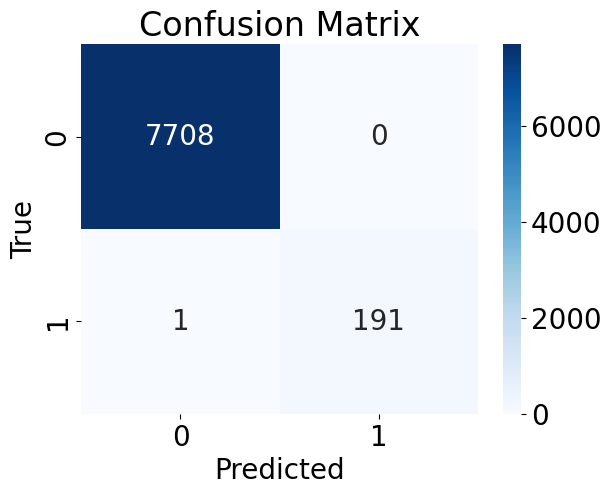

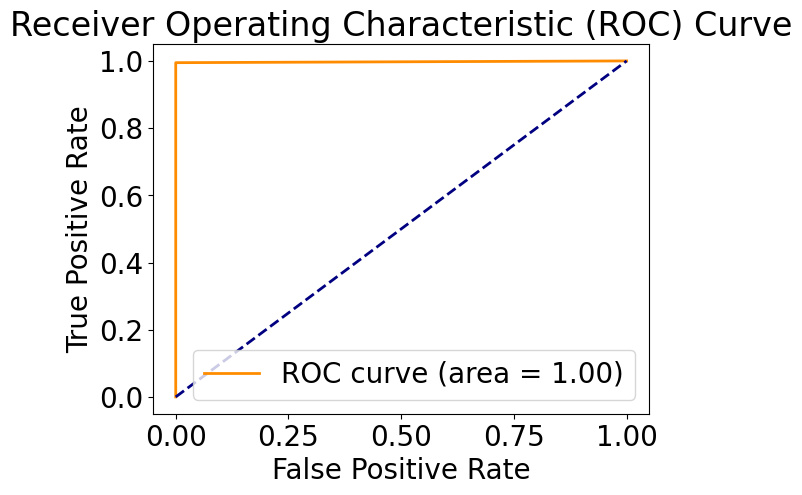

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense

# Reshape data for Conv1D
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# FCN Model Definition
def build_fcn(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

model_fcn = build_fcn(input_shape=(60, 1))
model_fcn.compile(optimizer='adam', loss=physics_informed_loss, metrics=['accuracy'])

# Train the model
history_fcn = model_fcn.fit(X_train_reshaped, y_train, epochs=10, validation_data=(X_test_reshaped, y_test))

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
# Get predictions for the test set
y_pred = model_fcn.predict(X_test_reshaped)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"RMSE: {rmse:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Recurrent Neural Network (RNN)

Epoch 1/10


C:\Users\Erfan Horeh\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


988/988 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9683 - loss: 0.1450 - val_accuracy: 0.9887 - val_loss: 0.0258
Epoch 2/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9948 - loss: 0.0132 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 3/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9994 - val_loss: 0.0018
Epoch 4/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.9991 - val_loss: 0.0032
Epoch 5/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9997 - val_loss: 6.7873e-04
Epoch 6/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9997 - val_loss: 5.5124e-04
Epoch 7/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9999 - val_loss: 5.6674e-04
Epoch 8/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9999 - loss: 4.7697e-

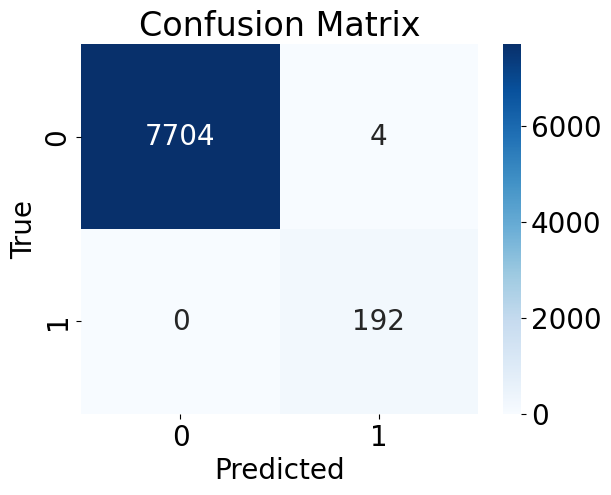

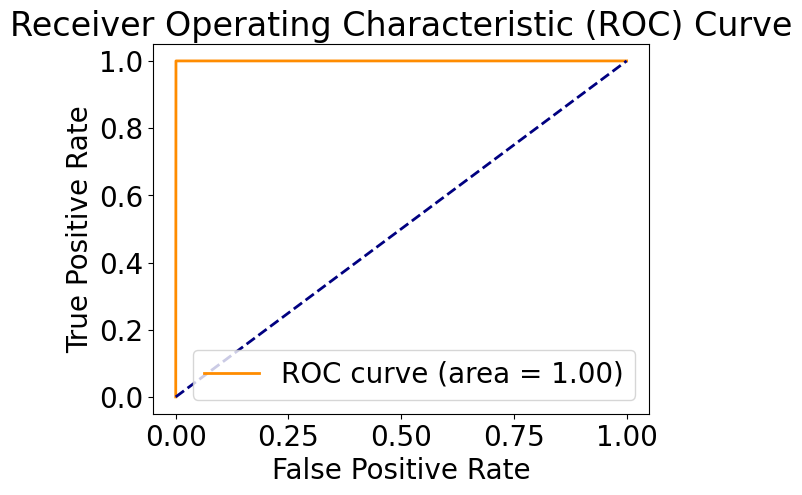

In [40]:
from tensorflow.keras.layers import LSTM

# RNN Model Definition
def build_rnn(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

model_rnn = build_rnn(input_shape=(60, 1))
model_rnn.compile(optimizer='adam', loss=physics_informed_loss, metrics=['accuracy'])

# Train the model
history_rnn = model_rnn.fit(X_train_reshaped, y_train, epochs=10, validation_data=(X_test_reshaped, y_test))

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
# Get predictions for the test set
y_pred = model_rnn.predict(X_test_reshaped)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"RMSE: {rmse:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Hybrid CNN-RNN Architecture

Epoch 1/10


C:\Users\Erfan Horeh\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


988/988 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9770 - loss: 0.0952 - val_accuracy: 0.9990 - val_loss: 0.0034
Epoch 2/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9982 - loss: 0.0051 - val_accuracy: 0.9961 - val_loss: 0.0102
Epoch 3/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9974 - loss: 0.0078 - val_accuracy: 0.9995 - val_loss: 0.0015
Epoch 4/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9995 - val_loss: 0.0017
Epoch 5/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9990 - val_loss: 0.0036
Epoch 6/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9975 - val_loss: 0.0056
Epoch 7/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9992 - loss: 0.0016 - val_accuracy: 0.9996 - val_loss: 8.5581e-04
Epoch 8/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.9996 

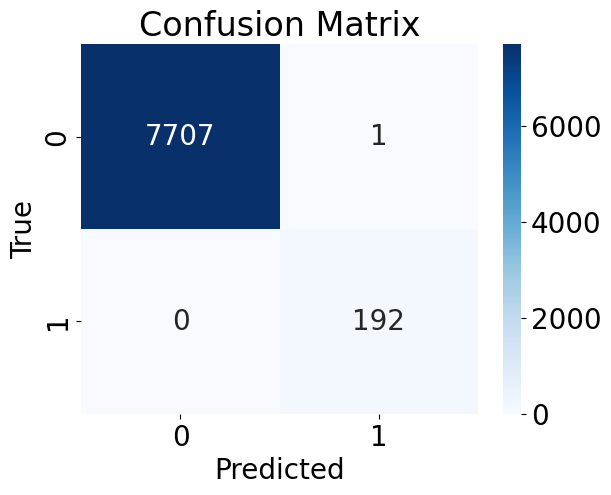

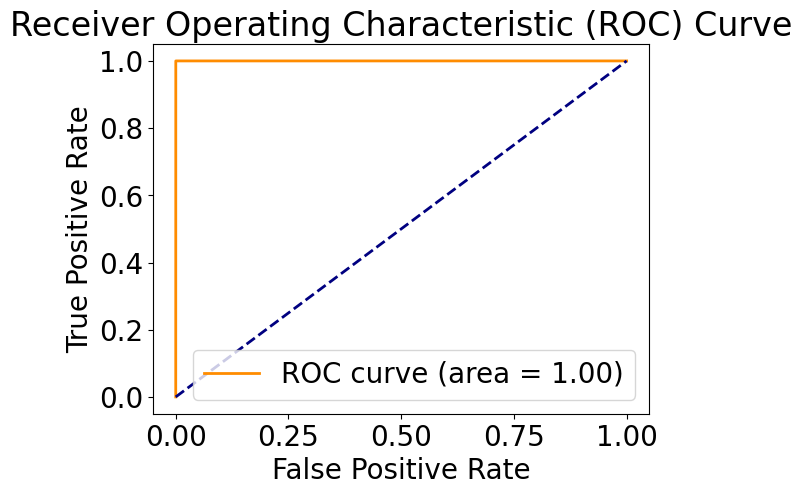

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

def build_cnn_rnn(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# Example usage
model_cnn_rnn = build_cnn_rnn(input_shape=(60, 1))
model_cnn_rnn.compile(optimizer='adam', loss=physics_informed_loss, metrics=['accuracy'])

# Train the model
history_cnn_rnn = model_cnn_rnn.fit(X_train_reshaped, y_train, epochs=10, validation_data=(X_test_reshaped, y_test))

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
# Get predictions for the test set
y_pred = model_cnn_rnn.predict(X_test_reshaped)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"RMSE: {rmse:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



## Training and Validation Accuracy:
### FCN
The model shows a high training accuracy that increases from 98.50% in Epoch 1 to 99.99% in Epoch 10.<br>
The validation accuracy starts at 99.91% and remains consistently high, reaching 99.97% at the end.<br>

### RNN
The training accuracy improves from 96.83% in Epoch 1 to 99.97% in Epoch 10.<br>
The validation accuracy is slightly lower than FCN, starting at 99.73% and reaching 99.99% in the last epoch.<br>

### Hybrid CNN-RNN
The training accuracy starts at 97.70% and gradually increases to 99.96% by the end.<br>
Validation accuracy starts at 99.96% and fluctuates slightly throughout, ending at 99.96%, but it has a notable dip to 99.05% at Epoch 8.<br>

## Training and Validation Loss:
### FCN
Training loss decreases rapidly from 0.0539 to 0.000514 by Epoch 10.<br>
Validation loss also decreases, from 0.0142 to 0.000487 by Epoch 10.<br>
The consistency in low loss values across training and validation suggests strong performance and minimal overfitting.<br>

### RNN
Training loss starts high at 0.1307 but decreases consistently to 0.000932 by Epoch 10.<br>
Validation loss follows a similar pattern, starting at 0.0085 and reducing to 0.000355 in Epoch 10.<br>
The lower validation loss in RNN than FCN suggests it is learning effectively, though it may not reach the minimal loss that FCN achieves.<br>

### Hybrid CNN-RNN
Training loss starts at 0.0864 and decreases to 0.0014 by Epoch 10.<br>
Validation loss fluctuates, starting at 0.0019, reaching a minimum of 0.000355 in Epoch 6, and then increasing in Epoch 8 to 0.0253, before dropping back down to 0.000742 by Epoch 10.<br>
The loss fluctuation in the validation set suggests instability, possibly due to the combined architecture's complexity or overfitting on some epochs.<br>

## Observations on Model Stability and Performance:
### FCN
The FCN performs the most consistently, with both training and validation accuracy steadily increasing while loss consistently decreases. This is a sign of good generalization without signs of overfitting.<br>

### RNN
The RNN has an effective performance, with both loss and accuracy showing improvement over epochs. However, it has more fluctuation in validation loss compared to FCN, suggesting that it might not generalize quite as well as FCN.<br>

### Hybrid CNN-RNN
This model demonstrates interesting behavior. Although the training loss improves significantly, the validation loss fluctuates considerably, especially at Epoch 8. This fluctuation may indicate potential overfitting or difficulty in balancing both convolutional and recurrent aspects, which might require further tuning or regularization.<br>

## Narrow vs. General AI:

Narrow AI is typically designed to solve specific problems (like classification or regression), while general AI involves systems that can perform any intellectual task that a human can do.

**Narrow AI:** The models implemented here (FCN, RNN, Hybrid CNN-RNN) are examples of narrow AI, as they are designed to perform a very specific task, like classifying ship signals in DAS data.
**General AI:** This is more theoretical and involves a system that can generalize across a wide range of tasks, potentially performing tasks it was never explicitly trained for.

For the dataset and models we’ve used:
These models perform exceptionally well on the specific task of ship signal classification, but they are narrow AI systems as they do not extend beyond that task.

## f-k plot of str-rate data

In [9]:
# Calculating FFT of the raw data
nnx, nns = str_rate.shape
fk_trace = np.fft.fftshift(np.fft.fft2(str_rate))
freq = np.fft.fftshift(np.fft.fftfreq(nns, d=1 / fs))
knum = np.fft.fftshift(np.fft.fftfreq(nnx, d=channels_chunk[2] * dx))

<function matplotlib.pyplot.show(close=None, block=None)>

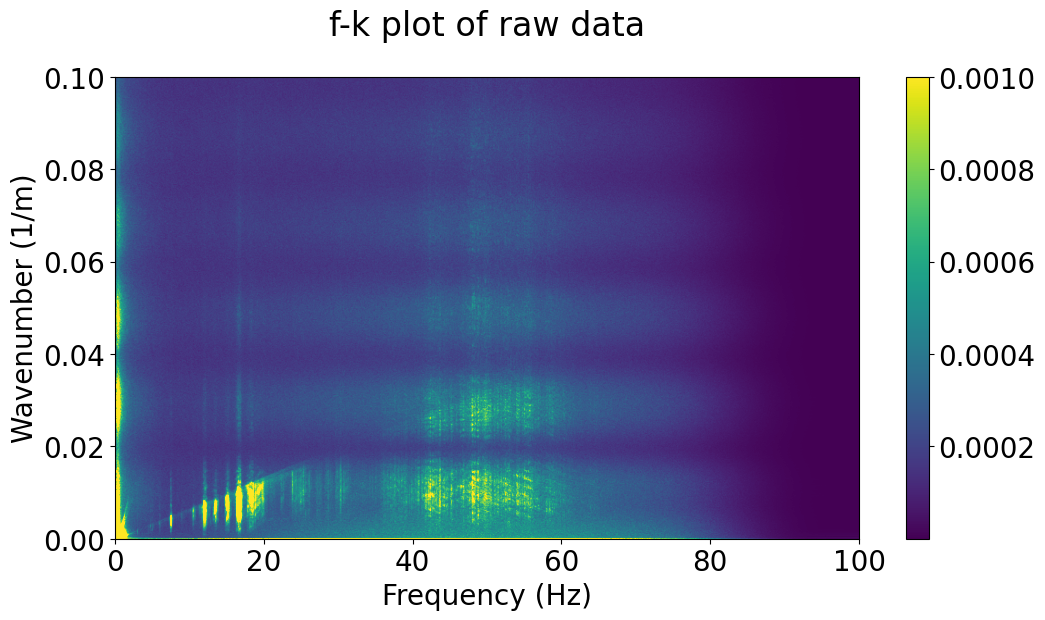

In [10]:
frq_max = 100
frq_min = 0
vmax = 0.001

# Plot the f-k spectrum
plt.figure(figsize=(12, 6))
shw = plt.imshow(np.abs(fk_trace), aspect='auto', extent=[freq[0], freq[-1], knum[0], knum[-1]], origin='lower', vmin=None, vmax=vmax)
plt.colorbar(shw)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Wavenumber (1/m)')
plt.xlim(frq_min, min(frq_max, fs/2))
plt.ylim(0, min(frq_max*0.001, 1/(2*dx)))
plt.title(f'f-k plot of raw data', pad=30)
plt.show

# Clustering Analysis for Classification Projects (Clustering_Analysis.ipnyb)


### Task: If your project involves classification, perform a clustering analysis on the features of your data, especially after dimensionality reduction.

Clustering Analysis for Classification is located in secondary named Clustering_Analysis.ipnyb due to pulling large quantity of data and taking over an hour to run to completion so it is completely seperated from the AutoML, Training Engineering + Model Assessment, and Computational Time Analysis sections.

# AutoML and Hyperparamter Tuning (AutoML_Hyperparameter_Tuning.ipnyb)

### Task: Use automated machine learning tools or perform a manual model hyperparameter search to find suitable models and settings for your problem.

### Making combined dataframe to input into the model

In [75]:
#make strain rate a pandas dataframe
import pandas as pd
df = pd.DataFrame(str_rate_reduced)

#add label to the distance and time
df.index.name = 'Distance'
df.columns.name = 'Time'

#find number of columns
num_columns = len(df.columns)
print(num_columns)


60


### Making metadata dataframe for section where ship noise occurs.

In [76]:
metadata = pd.DataFrame(index = df.index, columns = df.columns)
metadata = metadata.fillna(0)

# Defining distances where ship was present in our data
start_distance = 46000
end_distance = 48000

# add ship label to the metadata for points in the specified distance and time range from above
print(f"start channel: {int((start_distance-distance[0])/(dx*chint))}\nend channel: {int((end_distance-distance[0])/(dx*chint))}")
metadata.iloc[int((start_distance-distance[0])/(dx*chint)):int((end_distance-distance[0])/(dx*chint))] = 1
metadata

start channel: 22500
end channel: 23500


/tmp/ipykernel_14591/3199185620.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata = metadata.fillna(0)


Time,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
Distance,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Plotting metadata

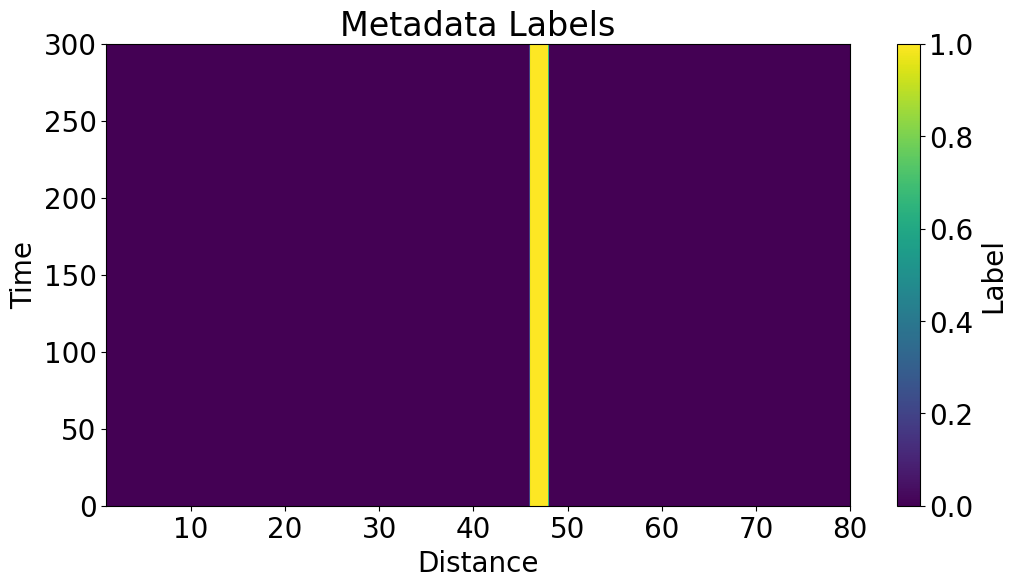

In [77]:
#plot the metadata to double check that the labels are correct and give values of 1 and 2 different colors
plt.figure(figsize=(12, 6))
plt.imshow(metadata.T, extent=[distance[0] * 1e-3, distance[-1] * 1e-3, duration[0], duration[-1]], aspect='auto', cmap='viridis')
plt.colorbar(label='Label')
plt.title('Metadata Labels')
plt.xlabel('Distance')
plt.ylabel('Time')
plt.show()

location appears to be correct based on where the ship noise is located from Erfan's earlier exploration. 1 = ship, 0 = noise

In [78]:
!pip install pycaret[full]

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.5 MB/s eta 0:00:00ta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 11.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flask to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 46.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 53.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 10.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 74.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
#indexing the dataframe for 1000 time snippets that contain ship noise but keep all distances
df_small = df.iloc[:, 40000:41000]

#pull one column of metadata to use as the target from metadata_small
metadata_small = metadata.iloc[:, 40999:41000]

#rename 204.995 to class
metadata_small.columns = ['class']

#put class and distance on same index row
metadata_small = metadata_small.reset_index()


#add metadata_small to the df_small dataframe
df_small['class'] = metadata_small['class']

#replace NaN values with 0
df_small = df_small.fillna(0)

# Find the closest index values for the given distances within the subset
start_distance_small = df_small.index.searchsorted(50500)
end_distance_small = df_small.index.searchsorted(52750)

# Replace values in class column between distances 50500 and 52750 with 1
df_small.iloc[start_distance_small:end_distance_small, df_small.columns.get_loc('class')] = 1


C:\Users\alexa\AppData\Local\Temp\ipykernel_2444\950944082.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['class'] = metadata_small['class']


In [79]:
#import pycaret for classification
from pycaret.classification import *

classification = setup(df.values, target = metadata.values)

best_classification = compare_models()

ModuleNotFoundError: No module named 'pycaret'

### Using tune_model to find optimal hyperparameters for lda and NB

In [52]:
#Print the best classification model to understand hyperparameters and other details
print(best_classification)

#also select lda because it was the best model in the previous run that did not overfit
best_lda = create_model('lda')

# tune model
tuned_lda = tune_model(best_lda)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9070,0.9585,0.8974,0.8974,0.8974,0.8123,0.8123
1,0.9070,0.9542,0.9487,0.8605,0.9024,0.8140,0.8175
2,0.9302,0.9498,0.9487,0.9024,0.9250,0.8599,0.8608
3,0.9419,0.9656,0.9744,0.9048,0.9383,0.8835,0.8856
4,0.8488,0.9067,0.8462,0.8250,0.8354,0.6957,0.6959
5,0.9302,0.9633,0.8684,0.9706,0.9167,0.8570,0.8609
6,0.8837,0.9792,0.8947,0.8500,0.8718,0.7655,0.7664
7,0.9529,0.9933,0.9474,0.9474,0.9474,0.9048,0.9048
8,0.9176,0.9339,0.9211,0.8974,0.9091,0.8338,0.8341


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9767,0.9989,0.9744,0.9744,0.9744,0.9531,0.9531
2,0.9767,0.9809,0.9744,0.9744,0.9744,0.9531,0.9531
3,0.9884,1.0000,1.0000,0.9750,0.9873,0.9766,0.9769
4,0.9884,1.0000,0.9744,1.0000,0.9870,0.9765,0.9768
5,0.9767,1.0000,1.0000,0.9500,0.9744,0.9531,0.9542
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9765,0.9787,0.9737,0.9737,0.9737,0.9524,0.9524


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Tuned model for LDA better than original

In [54]:
#select naive bayes since it is close to lda in performance
best_NB = create_model('nb')

# tune model
tuned_NB = tune_model(best_NB)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9302,0.9345,1.0000,0.8667,0.9286,0.8611,0.8695
1,0.8837,0.9182,0.9487,0.8222,0.8810,0.7684,0.7760
2,0.8605,0.9225,0.9744,0.7755,0.8636,0.7245,0.7444
3,0.8488,0.8860,1.0000,0.7500,0.8571,0.7034,0.7366
4,0.8721,0.9086,0.9231,0.8182,0.8675,0.7447,0.7498
5,0.8605,0.8843,1.0000,0.7600,0.8636,0.7261,0.7550
6,0.8605,0.9120,0.9211,0.7955,0.8537,0.7217,0.7288
7,0.8588,0.9087,0.9474,0.7826,0.8571,0.7201,0.7330
8,0.8235,0.8740,0.9474,0.7347,0.8276,0.6527,0.6749


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9302,0.9345,1.0000,0.8667,0.9286,0.8611,0.8695
1,0.8837,0.9182,0.9487,0.8222,0.8810,0.7684,0.7760
2,0.8605,0.9225,0.9744,0.7755,0.8636,0.7245,0.7444
3,0.8488,0.8860,1.0000,0.7500,0.8571,0.7034,0.7366
4,0.8721,0.9086,0.9231,0.8182,0.8675,0.7447,0.7498
5,0.8605,0.8843,1.0000,0.7600,0.8636,0.7261,0.7550
6,0.8605,0.9120,0.9211,0.7955,0.8537,0.7217,0.7288
7,0.8588,0.9087,0.9474,0.7826,0.8571,0.7201,0.7330
8,0.8235,0.8740,0.9474,0.7347,0.8276,0.6527,0.6749


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Evaluate best_classification

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

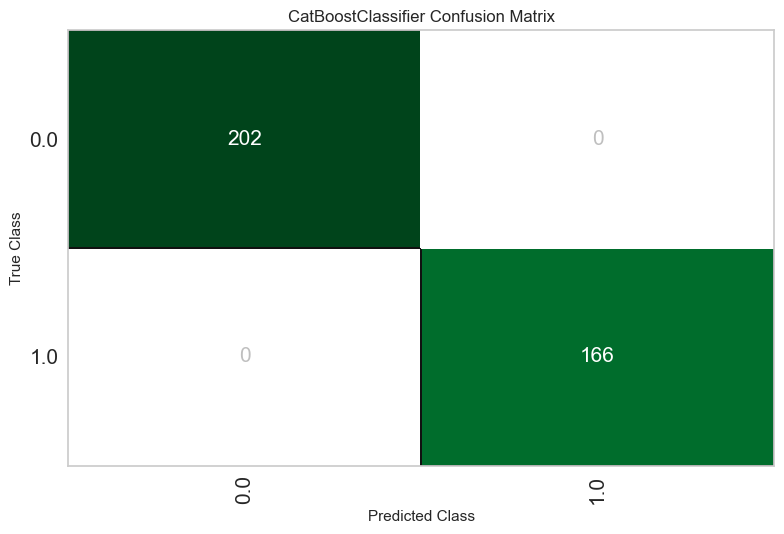

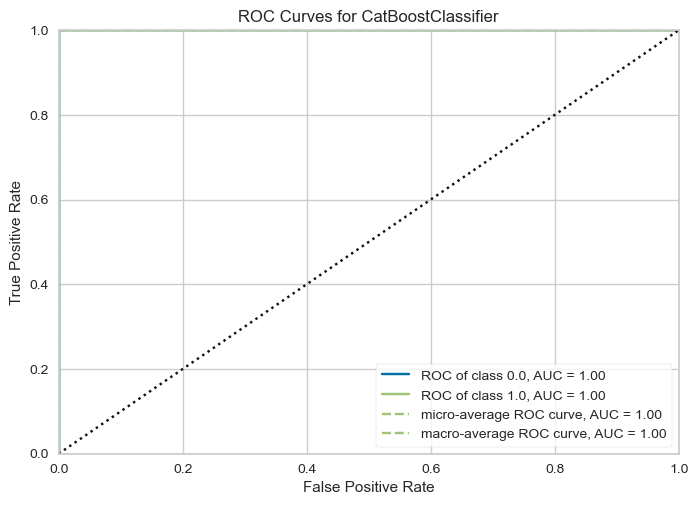

In [23]:
#Analyze and evalute the model
evaluate_model(best_classification)

#plot confusion matrix
plot_model(best_classification, plot = 'confusion_matrix')

#plot roc curve
plot_model(best_classification, plot = 'auc')

In [24]:
#predict model
DASpredict = predict_model(best_classification, data=df_small, raw_score=True) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [25]:
#save model for later use
save_model(best_classification, 'best_classification_DAS')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['200.0', '200.005', '200.01',
                                              '200.015', '200.02', '200.025',
                                              '200.03', '200.035', '200.04',
                                              '200.045', '200.05', '200.055',
                                              '200.06', '200.065', '200.07',
                                              '200.075', '200.08', '200.085',
                                              '200.09', '200.095', '200.1',
                                              '200.105', '200.11', '200.115',
                                              '200.12', '200.125...
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                          

### Evaluate tuned lda model

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

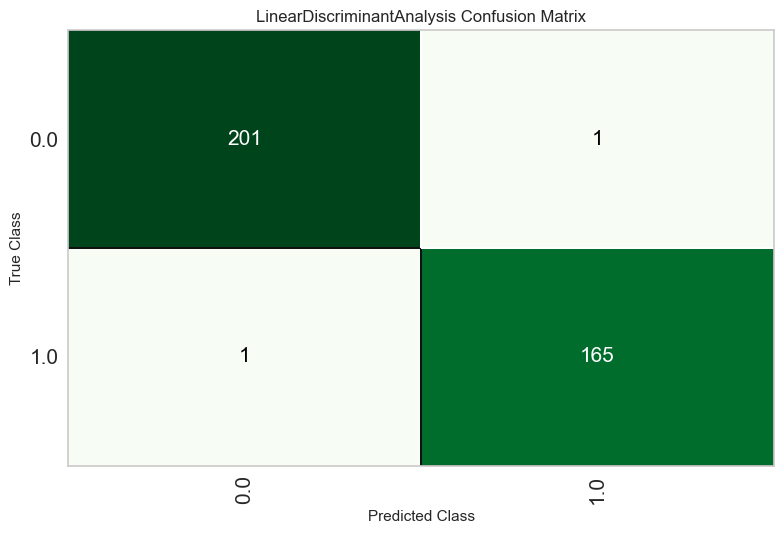

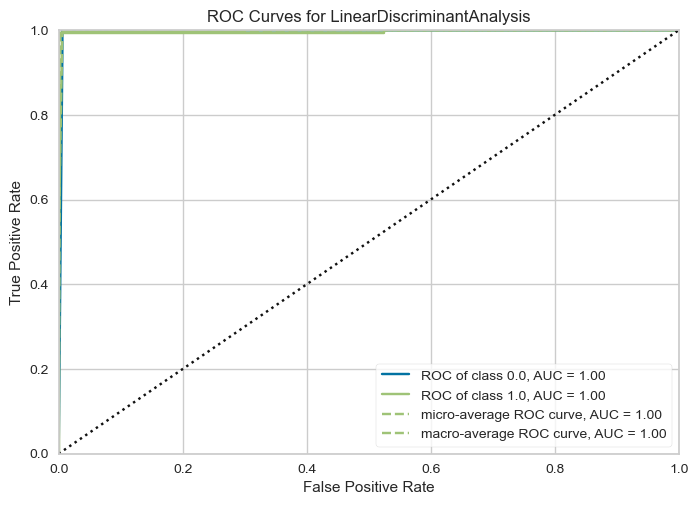

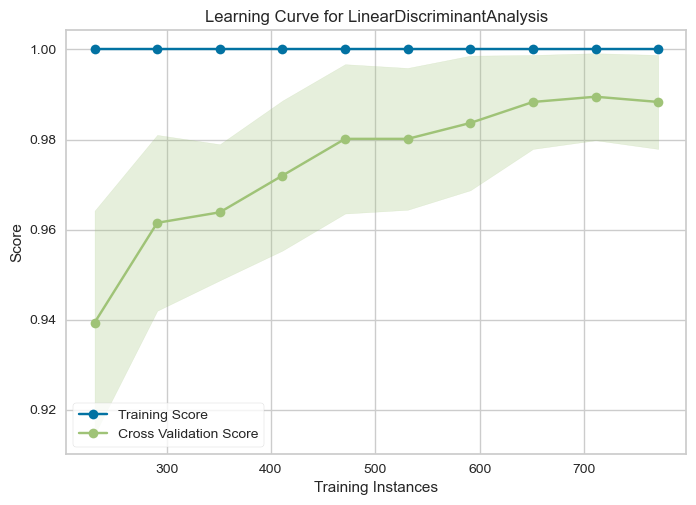

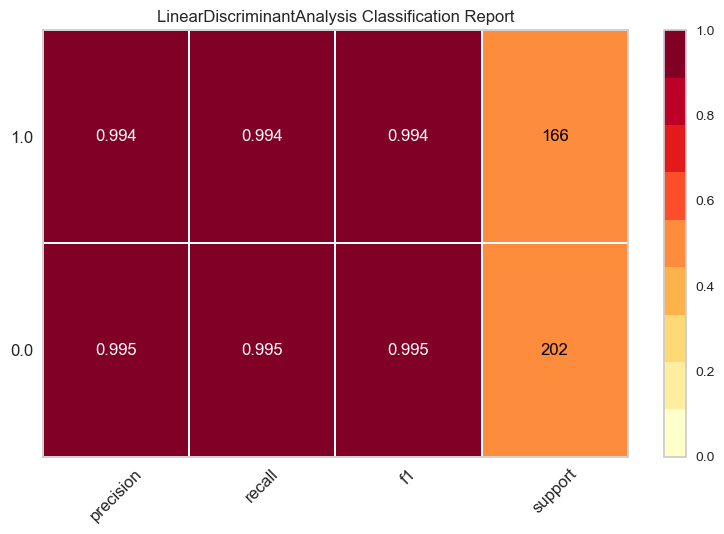

In [55]:
#Analyze and evalute the model
evaluate_model(tuned_lda)

#plot confusion matrix
plot_model(tuned_lda, plot = 'confusion_matrix')

#plot roc curve
plot_model(tuned_lda, plot = 'auc')

#plot learning curve
plot_model(tuned_lda, plot = 'learning')

#plot class report 
plot_model(tuned_lda, plot = 'class_report')


### Tuned LDA appears to now overfit so it may be better to use original model

In [44]:
#predict model
DASpredict_lda = predict_model(best_lda, data=df_small, raw_score=True) 


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.9437,0.9457,0.9474,0.9288,0.9380,0.8864,0.8866


In [45]:
#save model for later use
save_model(best_lda, 'best_lda_DAS')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['200.0', '200.005', '200.01',
                                              '200.015', '200.02', '200.025',
                                              '200.03', '200.035', '200.04',
                                              '200.045', '200.05', '200.055',
                                              '200.06', '200.065', '200.07',
                                              '200.075', '200.08', '200.085',
                                              '200.09', '200.095', '200.1',
                                              '200.105', '200.11', '200.115',
                                              '200.12', '200.125...
                                                               missing_values=nan,
                                                               strategy='most_frequent'))),
         

### evaluate NB

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

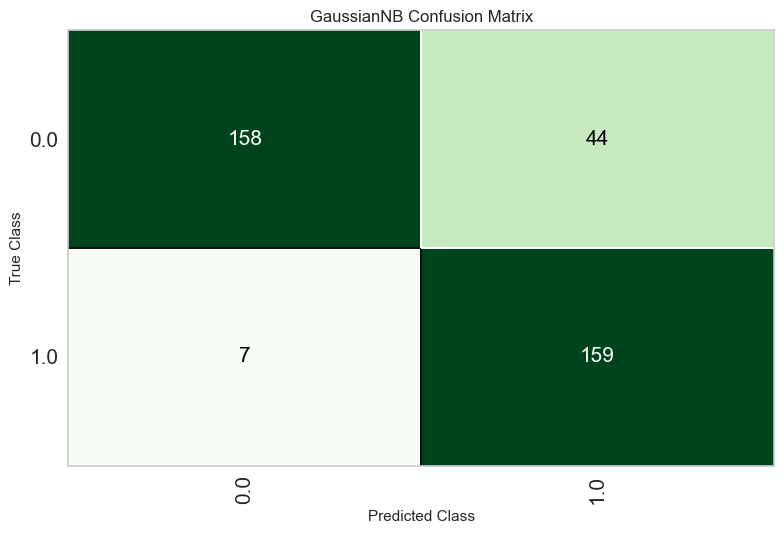

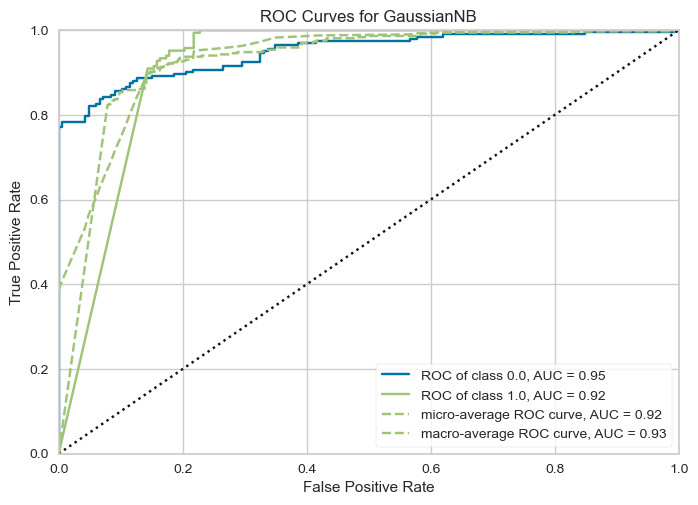

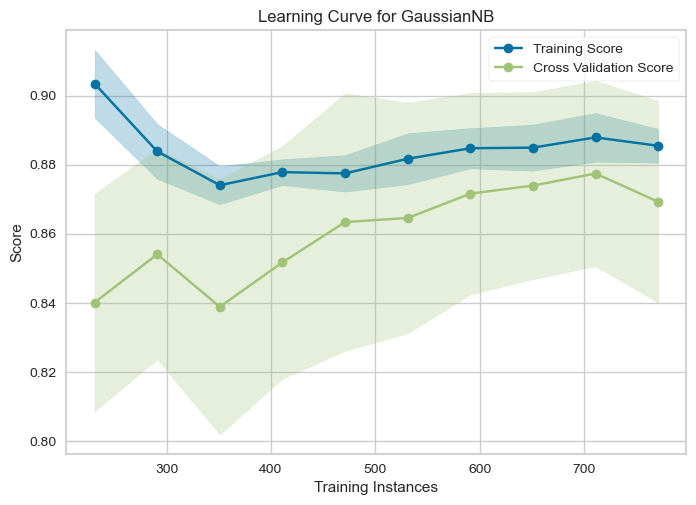

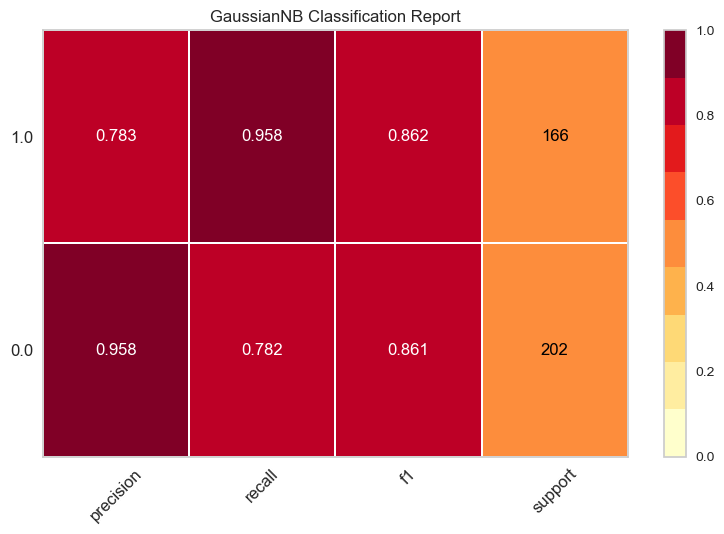

In [46]:
#Analyze and evalute the model
evaluate_model(best_NB)

#plot confusion matrix
plot_model(best_NB, plot = 'confusion_matrix')

#plot roc curve
plot_model(best_NB, plot = 'auc')

#plot learning curve
plot_model(best_NB, plot = 'learning')

#plot class report 
plot_model(best_NB, plot = 'class_report')



In [47]:
#predict model
DASpredict_NB = predict_model(best_NB, data=df_small, raw_score=True) 


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.8751,0.9216,0.9601,0.8015,0.8737,0.7521,0.7641


In [48]:
#save model for later use
save_model(best_NB, 'best_NB_DAS')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['200.0', '200.005', '200.01',
                                              '200.015', '200.02', '200.025',
                                              '200.03', '200.035', '200.04',
                                              '200.045', '200.05', '200.055',
                                              '200.06', '200.065', '200.07',
                                              '200.075', '200.08', '200.085',
                                              '200.09', '200.095', '200.1',
                                              '200.105', '200.11', '200.115',
                                              '200.12', '200.125...
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                          

### Description of algorithms evaluated + hyperparameters

The algorithms evaluated using AutoML were CatBoost Classifier, K Nieghbors Classifier, Extra Trees Classifier, Light Gradient Boosting Machine, Linear Discriminant Analysis, Naive Bayes, Quadratic Discriminant Analysis, Ada Boost Classifier, Gradient Boosting Classifier, Logistic Regression, Decision Tree Classifier, Ridge Classifier, Random Forest Classifier, Dummy Classifier, and SVM - Linear Kernel. 

The hyperparameters optimized -

For CatBoostClassifier, the hyperparameters used were nan_mode = Min, eval_metric = Logloss, iterations = 1000, sampling_frequency = PerTree, leaf_estimation_method = Newton, random_score_type = NormalWithModelSizeDecrease, grow_policy = SymmetricTree, penalties_coefficient = 1, boosting_type = Plain, model_shrink_mode = Constant, feature_border_type = GreedyLogSum, bayesian_matrix_reg = 0.10000000149011612, eval_fraction = 0, force_unit_auto_pair_weights = False, l2_leaf_reg = 3, random_strength = 1, rsm = 1, boost_from_average = False, model_size_reg = 0.5, pool_metainfo_options = {'tags': {}}, subsample = 0.800000011920929, use_best_model =False, class_names[0, 1], random_seed = 4405, depth = 6, posterior_sampling = False, border_count = 254, classes_count = 0, auto_class_weights = None, sparse_features_conflict_fraction = 0, leaf_estimation_backtracking = AnyImprovement, best_model_min_trees = 1, model_shrink_rate = 0, min_data_in_leaf = 1, loss_function = Logloss, learning_rate = 0.009645000100135803, score_function = Cosine, task_type = CPU, leaf_estimation_iterations = 10, bootstrap_type = MVS, and max_leaves = 64.

For LDA, the hyperparameters optimized were the covariance_estimator = none, n_components = none, priors = none, shrinkage = 0.05, solver = lsqr, store_covariance  = false, and tol = 0.0001.

For NB, the hyperparameters optimized were priors = none and var_smoothing = 1e-09.


### Most promising models

The most promising models trained with only 1 ship appeared to be the CatBoostClassifier as it had near 99% accuracy, precision, f1 score, etc.. Linear Discriminant Analysis and Naive Bayes were the to next promising models that were not near 99% (in the rang of 80% - 90%) to make sure CatBoostClassifier is not overfitting.  The Linear Discrimant Analysis had accuracies around 90% when untuned and 99% when tuned and Naive Bayes had accuracies closer to 80% to 90% and the computational time is much quicker than the CatBoostClassifier. The interpretability from viewing the different parameters displayed gave more interpretability to CatBoostClassifier vs. LDA and NB because the classifying boundary for the last 2 have multiple classes in the wrong boundary. Based on hyperparameters: NB is the most interpretable followed by LDA and CatBoostClassifier. The computation cost of the models we based on computational time. The highest computation cost would be the CatBoostClassifier, lower would be the LDA, and lowest would be Naive Bayes. 


# Training Engineering and Model Assessment (Model_Training_Assessment.ipynb)

##### Task: Perform a thorough analysis of training strategies and model assessment.

##### Utilizing cross-validation on LinearDiscriminantAnalysis due to being average in accuracy and time

In [49]:
# Evaluating Linear Discriminant Analysis model with cross validation and train-val-test using sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Splitting the data into train and test sets
X = df_small.drop('class', axis=1)
y = df_small['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predicting the model
y_pred = lda.predict(X_test)

# report of classification
print("LDA1 classification report")
print(classification_report(y_test, y_pred))

# do cross validation 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lda, X, y, cv=28)

print("LDA1", scores)


LDA1 classification report
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       129
         1.0       0.74      0.77      0.75       116

    accuracy                           0.76       245
   macro avg       0.76      0.76      0.76       245
weighted avg       0.76      0.76      0.76       245

LDA1 [0.88636364 0.84090909 0.86363636 0.86363636 0.47727273 0.72727273
 0.95454545 0.97727273 0.93181818 1.         0.88636364 0.84090909
 0.97727273 0.70454545 0.97727273 0.88636364 0.95454545 0.81818182
 0.90909091 0.88636364 0.79545455 0.76744186 0.6744186  0.90697674
 0.95348837 0.97674419 0.88372093 0.72093023]


In [50]:
# test the model on different subsections of the data with similar classes
# select different subsection

df_small2 = df.iloc[:, 41000:42000] # can use same class file as df_small2+3 are in same ship range

X2 = df_small2

# train test split the model
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

# Training the model for 2
lda2 = LinearDiscriminantAnalysis()
lda2.fit(X_train, y_train)

# Predicting the model
y_pred2 = lda2.predict(X_test)

# report of classification
print("LDA2 classification report")
print(classification_report(y_test, y_pred))

# do cross validation 
from sklearn.model_selection import cross_val_score
scores2 = cross_val_score(lda2, X, y, cv=8)

print("LDA2 scores", scores2)

# bootstrap and bagging on the model
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(lda2, n_estimators=10, random_state=42, bootstrap = True)
scores2_bag = cross_val_score(bag, X2, y, cv=8)
print("LDA2 Bag Scores are", scores2_bag)


LDA2 classification report
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       129
         1.0       0.74      0.77      0.75       116

    accuracy                           0.76       245
   macro avg       0.76      0.76      0.76       245
weighted avg       0.76      0.76      0.76       245

LDA2 scores [0.44805195 0.65359477 0.94117647 0.69934641 0.90196078 0.67320261
 0.62091503 0.70588235]
LDA2 Bag Scores are [0.86363636 0.79084967 0.98039216 0.99346405 0.99346405 0.92810458
 1.         0.89542484]


In [51]:
#crossval, train-val-test + bootstrap and bagging on the NaiveBayes model
from sklearn.naive_bayes import GaussianNB

#dataset 1
# fitting the model
GNB = GaussianNB()
GNB.fit(X_train, y_train)

# Predicting the model
y_predGB = GNB.predict(X_test)

# report of classification
print("GNB1 classification report")
print(classification_report(y_test, y_predGB))

# cross validation
scoresGB = cross_val_score(GNB, X, y, cv=8)
print("GNB1", scoresGB)

# dataset 2
# fitting the model
GNB2 = GaussianNB()
GNB2.fit(X2_train, y_train)

# Predicting the model
y_predGB2 = GNB2.predict(X_test)

# report of classification
print("GNB2 classification report")
print(classification_report(y_test, y_predGB2))

# cross validation
scoresGB2 = cross_val_score(GNB2, X2, y, cv=8)
print("GNB2", scoresGB2)

# bootstrap and bagging on the model
bagGB2 = BaggingClassifier(GNB2, n_estimators=10, random_state=42, bootstrap = True)
scoresGB2_bag = cross_val_score(bagGB2, X2, y, cv=8)
print("GNB2 Bag Scores are", scoresGB2_bag)




GNB1 classification report
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       129
         1.0       0.83      0.97      0.90       116

    accuracy                           0.89       245
   macro avg       0.90      0.90      0.89       245
weighted avg       0.91      0.89      0.89       245

GNB1 [0.35064935 0.66666667 0.53594771 1.         1.         0.60784314
 0.47712418 0.91503268]
GNB2 classification report
              precision    recall  f1-score   support

         0.0       0.60      0.65      0.62       129
         1.0       0.57      0.52      0.54       116

    accuracy                           0.59       245
   macro avg       0.59      0.58      0.58       245
weighted avg       0.59      0.59      0.59       245

GNB2 [0.33116883 0.66013072 0.65359477 0.96078431 1.         0.92156863
 1.         0.98039216]
GNB2 Bag Scores are [0.31168831 0.66013072 0.64705882 0.96078431 1.         0.93464052
 0.99346405 0

### AutoML framework shows learning curves and accuracy plots across trainings with cross validation methods implemented as well to fulfill requirement from earlier steps.

# Computational Time Analysis (Computational_Time_Analysis.ipynb)

### Task: Analyze the computational time needed for model training and deployment.

#### Metrics on Training Time: Grabbed from AutoML

Of the three models we evaluated in deeper depth CatBoostClassifier took the largest total time to train for a dataset 1225 x 1000 of str_rate. It took a total of 86 seconds when run for this subset of data. The number of hyperparameters for this classifier was much greater than the other two which is why I believe it took much longer.

The next largest time was the LinearDiscriminantAnalysis which took .17 seconds for the same 1225 x 1000 dataset. The LDA had a total of 7 parameters which is much less than the CatBoostClassifier, but more than NaiveBayes. It took the middle amount of time to classify which I believe is because of the # of hyperparameters used.

The shortest time was the NaiveBayes which took 0.095 seconds for the identical 1225 x 1000 dataset. It had a total of two hyperparameters analyzed which led to it having the shortest time.

#### An exploration of time vs. accuracy trade-offs for different configurations.

CatBoostClassifer had the highest accuracy of the three which was >99% accuracy but took the longest compared to the other two at 88 seconds. LinearDiscriminantAnalysis had the next highest accuracy of ~90% which was much quicker at .17 seconds. NaiveBayes took the shortest at 0.095 seconds and had an accuracy around ~87%. 

#### An assessment of expected time requirements for model deployment in real-world scenarios.

The time snippet of data utilized was 5 seconds total of DAS data. If we take the same ratios of time to look at the same ~600 meters of cable for the whole dataset it would take 344 days for CatBoostClassifier to run the data, it would take 0.68 days for LinearDiscriminantAnalysis to go through it, and would take 0.38 days for Naive Bayes. The total length of the cable is around 100x larger than sectioned length, so to do the whole dataset we predict is would take a less than 100 years for CatBoostClassifier, 68 days for LDA, and 38 for NaiveBayes using a regular microsoft surface laptop without a dedicated gpu.

### Summary of Findings

Based on the computational time metrics we evaluated it looks like it is going to be a challenge utilizing the whole DAS dataset due to the pure size of it. Our project will likely need a large computational power in order to analyze the dataset to the extent we need and CatBoostClassifier will likely not be used due to the imense amount of time it needs. LDA or NB is a much better option time wise due to relatively high accuracy that does not seem to overfit. Again, the large size ~26tb will make this challenging.